In [1]:
%%writefile rotation.py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from trajectories import Trajectories
test_traject = 5

traject = Trajectories()
Xs, y, y_inicial = traject.generate_train_test_trajects(test_traject)

def rotate(tra, ang):
    
    theta = (ang/180) * np.pi
    device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
    
    

    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                     [np.sin(theta),  np.cos(theta)]])
    
    r = torch.zeros_like(tra).cpu().detach().numpy()
    print(r.ndim)
    if r.ndim == 3:
        for k in range(0, tra.size()[0]):
            tra1 = tra.cpu().detach().numpy()
            r[k,:,:] = tra1[k,:,:]@rot_matrix
    elif r.ndim == 4:
        for j in range(0, tra.size()[0]):
            for k in range(0, tra.size()[1]):
                tra1 = tra.cpu().detach().numpy()
                r[j,k,:,:] = tra1[j,k,:,:]@rot_matrix
    else:
            tra1 = tra.cpu().detach().numpy()
            r[:,:] = tra1[:,:]@rot_matrix
    return r

# y2 = rotate(y, 90)
# y_inicial2 = rotate(y_inicial, 180)

# fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)

# ax1.plot(y[0,:,0].cpu().detach().numpy(), y[0,:,1].cpu().detach().numpy(), c = 'r', label = 'original', marker = '.')
# plt.legend()

# ax2.plot(y2[0,:,0], y2[0,:,1], c = 'b', label = 'rotated', marker = '.')
# plt.legend()

Writing rotation.py


In [2]:
%%writefile trajectories.py
import numpy as np
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

mini_batch_size = 128
N_mini_batch = 130
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi

class Trajectories:

    def generate_train_test_trajects(self, type_traject):
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
        print(f'Is cuda available in trajectories.py?: {torch.cuda.is_available ()}')
        
        Xs_t = torch.zeros([type_traject,N_despl,N_coord], device=device) 
        y_t = torch.zeros([type_traject,N_despl,N_coord], device=device)
        y_inicial = torch.zeros([type_traject,N_coord], device=device)

#         Xs_t = Xs_t.to (device)
#         y_t = y_t.to (device)
#         y_inicial = y_inicial.to (device)
        
        print(f'Device cuda for y_inicial in trajectories.py:{y_inicial.is_cuda}')
        for k in range(type_traject):
            d360 = np.pi * 2
            ranX = np.zeros(N_despl)  
            des = np.ones(N_despl)*0.05

            for j in range(N_despl):
                if j == 0:
                    ranX[j] = float(np.random.uniform(0, d360, 1))
                else:
                    #ranX[j] = 0.95*ranX[j-1] + 0.05*(np.pi - float(np.random.uniform(0, d360, 1)))
                    ranX[j] = ranX[j-1] + float(np.random.uniform(-d360*0.1, d360*0.1, 1))


            cos = np.cos(ranX)

            sin = np.sin(ranX)

            ranY = []
            for i in range(len(cos)):
                ranY.append(des[i] / cos[i])

            Xak = []


            for i in range(len(ranX)):
                list1 = []
                list1.append(cos[i]*des[i])
                list1.append(sin[i]*des[i])
                Xak.append(list1)

            ylistk = []
            inicial = []

            for i in range(len(ranX)):
                coords = []
                if i == 0:
                    x_cond_in = float(np.random.uniform(limit_arena2+np.abs(Xak[i][0]), limit_arena-np.abs(Xak[i][0]), 1))
                    y_cond_in = float(np.random.uniform(limit_arena2+np.abs(Xak[i][1]), limit_arena-np.abs(Xak[i][1]), 1))
                    coords.append(Xak[i][0] + x_cond_in)
                    coords.append(Xak[i][1] + y_cond_in)
                    ylistk.append(coords)  # posiciones iniciales en x e y
                    inicial.append(x_cond_in)
                    inicial.append(y_cond_in)
                else:
                    x_coord = cos[i]*des[i] + ylistk[i - 1][0]
                    y_coord = sin[i]*des[i] + ylistk[i - 1][1]
                    if limit_arena2 < y_coord < limit_arena and limit_arena2 < x_coord < limit_arena:
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    elif x_coord <= limit_arena2 or x_coord >= limit_arena:
                        x_coord = ylistk[i - 1][0]
                        y_coord = ylistk[i - 1][1]
                        cos[i:] = np.cos (ranX[i:] + grad_90)
                        sin[i:] = np.sin (ranX[i:] + grad_90)
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    elif y_coord <= limit_arena2 or y_coord >= limit_arena:
                        x_coord = ylistk[i - 1][0]
                        y_coord = ylistk[i - 1][1]
                        cos[i:] = np.cos (ranX[i:] + grad_90)
                        sin[i:] = np.sin (ranX[i:] + grad_90)
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif x_coord <= limit_arena2:
                    #     x_coord = limit_arena
                    #     if y_coord < limit_arena2:
                    #         y_coord = limit_arena
                    #     if y_coord > limit_arena:
                    #         y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif x_coord >= limit_arena:
                    #     x_coord = limit_arena2
                    #     if y_coord < limit_arena2:
                    #         y_coord = limit_arena
                    #     if y_coord > limit_arena:
                    #         y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif y_coord <= limit_arena2:
                    #     y_coord = limit_arena
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif y_coord >= limit_arena:
                    #     y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)


            Xsk = torch.tensor([Xak], device=device)
            yk = torch.tensor([ylistk], device=device)
            inicial = torch.tensor([inicial], device=device)

            y_inicial[k,:] = inicial
            Xs_t[k,:,:] = Xsk
            y_t[k,:,:] = yk

            
            Xs = Xs_t
            y = y_t      
            

        return Xs, y, y_inicial
print("trajectories")

Writing trajectories.py


In [3]:
%%writefile model.py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

N_despl = 2
N_input_neurons = 4
N_hidden_neurons = 100
N_softmax_neurons = 20

class NeuralNetwork(nn.Module):
            
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.linear = nn.Linear(N_input_neurons, N_hidden_neurons, bias=False) #probar otra inicializacion, xavier
        nn.init.xavier_uniform_(self.linear.weight, gain=0.9)
        #nn.init.zeros_(self.linear.weight)
        self.Tanh = nn.ReLU() 

        self.M = torch.randn((N_despl, N_hidden_neurons))*0.01
        self.M = torch.nn.Parameter(self.M)


        self.linear2 = nn.Linear(N_hidden_neurons, N_hidden_neurons, bias=False)
        nn.init.orthogonal_(self.linear2.weight, gain=0.9)
        #nn.init.zeros_(self.linear2.weight)
        self.Tanh2 = nn.ReLU()
        
        

        self.linear4 = nn.Linear(N_hidden_neurons, N_softmax_neurons, bias=False)
        nn.init.xavier_uniform_(self.linear4.weight, gain=0.9)
        #nn.init.zeros_(self.linear4.weight)

        #self.dropout = nn.Dropout(p=0.70)
        
        self.linear5 = nn.Linear(N_softmax_neurons, N_hidden_neurons, bias=False)
        nn.init.zeros_(self.linear5.weight)
        
        #seguir probando sin capa 'retro'

        self.softmax = nn.Softmax(dim=1)

        self.linear3 = nn.Linear(N_softmax_neurons, N_despl, bias=False)
        nn.init.xavier_uniform_(self.linear3.weight, gain=0.9)
        #nn.init.zeros_(self.linear3.weight) 


        #empiezo probando w_ini mas chico en capa salida, pero luego unificar todas (xavier init)
        #probar N_softmax_neurons mas chico
        
    def forward(self, input, x0, xretro):
         
        xin = self.linear(input)
        #noise =  torch.empty(x0.size(), device='cuda:0').normal_(mean=0,std=0.7)

        u0 = self.Tanh(x0)
        xrec = self.linear2(u0)       
        dx = (-x0 + xin + xrec + xretro) / 10 
        x1 = x0 + dx
        
        def add_noise(weights, noise):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
            weights.add_(noise)
        
        #r = 0.4
        #noise_linear2 = torch.randn(x1.size(), device='cuda:0')*r 
        
        
        #add_noise(x1, noise_linear2) #acotar para que el ruido complique 
         
        #adam diferente const aprendizaje para cada parametro    
        
        x2 = self.Tanh(x1)
        x2c = torch.clamp(x2, min=None, max=1)

        #x2cd = self.dropout(x2c)
        
        x3 = self.linear4(x2c)
        beta = 1.5
        x4 = x3*beta
        x5 = self.softmax(x4)
        
        xretro = self.linear5(x5)
        
        s = 0.02
        noise_linear3 = torch.randn(x5.size(), device='cuda:0')*s

        x6 = x5 + noise_linear3
        u1 = self.Tanh(x5)  
        yd = self.linear3(u1)
        

        return yd, x1, x3, xretro
    
    #mas neuronas
    #retroconexion de softmax a recurrente
    #division por norma de vector en lugar de softmax
    
    #batch-normalization? +mu / sigma


Writing model.py


In [4]:
import torch
import numpy as np
device = torch.device ("cpu")
permutationX = torch.randperm(10)
half = int(permutationX.detach().numpy().size/2)
permutationX2 = permutationX[0:half]
permutationX3 = permutationX[half:]
print(permutationX)
print(permutationX2)
print(permutationX3)
p = torch.cat((permutationX2, permutationX3))

print(p)

tensor([4, 7, 1, 9, 2, 0, 6, 8, 3, 5])
tensor([4, 7, 1, 9, 2])
tensor([0, 6, 8, 3, 5])
tensor([4, 7, 1, 9, 2, 0, 6, 8, 3, 5])


In [5]:
def distancia_modelo_real(tensor1, tensor2):
    x_distance = np.mean (np.abs ((tensor1[:, 0] - tensor2[:, 0])) / (np.max (tensor1[:, 0]) - np.min (tensor1[:, 0])))
    y_distance = np.mean (np.abs ((tensor1[:, 1] - tensor2[:, 1])) / (np.max (tensor1[:, 1]) - np.min (tensor1[:, 1])))
    return x_distance, y_distance
print('done')

done


In [6]:
%%writefile test.py
import numpy as np
import torch
import torch.nn as nn
from model import NeuralNetwork
from trajectories import Trajectories
from rotation import rotate

mini_batch_size = 128
N_mini_batch = 130
test_traject = 256
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi
N_despl = 20
N_coord = 2
N_hidden_neurons = 100
N_softmax_neurons = 20

beta = 1.5



class Testing:

    
    def test_model(self):
        
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
        degree = 45
        my_network = NeuralNetwork()
        my_network.to(device)
        my_network.M.to (device)
        
        
        mseloss = nn.MSELoss()
        #optimizer = torch.optim.Adam(my_network.parameters(), lr = 0.01)
        
        traject = Trajectories()

        torch.save(my_network,'/kaggle/working/MyNetworkKaggleTest7.tar')
        
        batch_y1 = torch.zeros(test_traject,N_despl,N_coord, device=device)
        y2 = torch.zeros(test_traject,N_despl,N_coord, device=device)
        
        all_activation_test = torch.zeros(test_traject, N_despl, N_hidden_neurons, device=device)
        all_activation_soft_test = torch.zeros(test_traject, N_despl, N_softmax_neurons, device=device)
        
        Xs, y, y_inicial = traject.generate_train_test_trajects(test_traject)
        
        
        y_rot = rotate(y, degree)
        y_inicial_rot = rotate(y_inicial, degree)
        
        y_rot1 = torch.from_numpy(y_rot)
        y_rot1 = y_rot1.to(device)
        y_inicial_rot1 = torch.from_numpy(y_inicial_rot)
        y_inicial_rot1 = y_inicial_rot1.to(device)
        
        context_signal = torch.tensor([[1, 0], [0, 1]], device=device)
        
        my_network.eval()
        
        with torch.inference_mode():
            permutationX = torch.randperm(Xs.size()[0], device=device)
            test_batch = 128
            
            for i in range(0,Xs.size()[0], test_batch): #iterate minibatch

                activation = torch.zeros ((test_batch,N_despl, N_hidden_neurons), device=device)
                activation_soft = torch.zeros ((test_batch,N_despl, N_softmax_neurons), device=device)


                # remove current gradients for next iteration
                #optimizer.zero_grad(set_to_none=True)
        
                firings = torch.zeros((test_batch, N_hidden_neurons), device=device)
                #firings = firings.to(device)
                firings_soft = torch.zeros((test_batch, N_softmax_neurons), device=device)
                #firings_soft = firings_soft.to(device)

                indicesX = permutationX[i:i + test_batch]
                half = int(indicesX.cpu().detach().numpy().size/2)
                indicesX2 = indicesX[0:half]
                indicesX3 = indicesX[half:]
                
                
                batch_y2 = y[indicesX2]
                batch_y3 = y_rot1[indicesX3]

                batch_y = torch.cat((batch_y2, batch_y3), dim=0)
                
                #Targets cambiados
                batch_y2_switch = y[indicesX3]
                batch_y3_switch = y_rot1[indicesX2]

                batch_y_switch = torch.cat((batch_y2_switch, batch_y3_switch), dim=0)
                
                batch_x2 = Xs[indicesX2]
                batch_x3 = Xs[indicesX3]
                context_signal2 = context_signal[0].repeat(batch_x2.size()[0], batch_x2.size()[1], 1)
                context_signal3 = context_signal[1].repeat(batch_x3.size()[0], batch_x3.size()[1], 1)
                
#                 print(f'context_signal[0].size()={context_signal[0].size()}')
#                 print(f'context_signal[0]={context_signal[0]}')
#                 print(f'context_signal2.size()={context_signal2.size()}')
#                 print(f'batch_x2.size()={batch_x2.size()}')
                
                batch_x2 = torch.cat((batch_x2, context_signal2), dim=2)
                batch_x3 = torch.cat((batch_x3, context_signal3), dim=2)
                
                batch_x = torch.cat((batch_x2, batch_x3), dim=0)
                
#                 print(f'batch_x.size()={batch_x.size()}')
#                 print(f'batch_x elemento={batch_x[0,:,:]}')
                
                vect2 = y_inicial[indicesX2]
                vect3 = y_inicial_rot1[indicesX3]
                
                vect = torch.cat((vect2, vect3), dim=0)
                
                x0 = vect@my_network.M
                xretro = torch.zeros((test_batch, N_hidden_neurons), device=device)
                
                ytotal = torch.zeros(test_batch,N_despl,2, device=device)
                for k in range(0, Xs.size()[1]):  # iterate time

                    # input training example and return the prediction
                    yhat, x0, x3, xretro = my_network.forward(batch_x[:,k,:], x0, xretro)
                    ytotal[:,k,:] = yhat

                    firing = torch.relu(x0)
                    activation[:,k,:] = firing

                    firing2 = x3
                    firing2 *= beta
                    firing_soft = torch.softmax(firing2, dim=1)
                    activation_soft[:,k,:] = firing_soft

                batch_y1[i:i + test_batch,:,:] = batch_y.detach()
                y2[i:i + test_batch,:,:] = ytotal.detach()


                all_activation_test[i:i + test_batch,:,:] = activation.detach()
                all_activation_soft_test[i:i + test_batch,:,:] = activation_soft.detach()


                # calculate MSE loss
                # coef = 0.05
                loss1 = mseloss(ytotal, batch_y)
                loss_switch = mseloss(ytotal, batch_y_switch)
                
                # loss2 = firings_mean
                # loss = loss1 * (1 - coef) + loss2 * coef
                #
                # # append to loss
                # current_loss += loss
        return loss1, loss_switch, all_activation_test, all_activation_soft_test, batch_y1, y2, my_network



Writing test.py


In [7]:
degree = 45

In [8]:
%%writefile train.py
import os
import numpy as np
import torch
import torch.nn as nn
from model import NeuralNetwork
from trajectories import Trajectories
from rotation import rotate

mini_batch_size = 128
half_minibatch = int(mini_batch_size/2)
qu_minibatch = int(mini_batch_size/4)
N_mini_batch = 130
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)

train_traject2 = int(train_traject/2)

test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
N_input_neurons = 4
N_hidden_neurons = 100
N_softmax_neurons = 20
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi

beta = 1.5


def add_noise(weights, noise):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    weights.add_(noise)  

class Training:
    
    
    
    def train_model(self):
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
        print(f'Is cuda available in train.py?: {torch.cuda.is_available ()}')

        my_network = NeuralNetwork()
#         my_network.to(device)
#         my_network.M.to (device)
        
        #my_network = torch.load('/kaggle/working/MyNetworkKaggle5.tar')
        my_network.to(device)
        my_network.M.to (device)
        epochs = 250
        degree = 45
        
        
        mseloss = nn.MSELoss()
        
        optimizer = torch.optim.Adam(my_network.parameters(), lr = 0.01)
        
        
#         optimizer = torch.optim.Adam(
#                         [
#                             {"params": my_network.linear.parameters(), "lr": 1e-3},
#                             {"params": my_network.linear3.parameters(), "lr": 1e-3},
#                             {"params": my_network.linear4.parameters(), "lr": 1e-3},
#                             {"params": my_network.linear2.parameters(), "lr": 1e-3},
#                             {"params": my_network.linear5.parameters(), "lr": 1e-3},
#                         ],
#                         lr=1e-3,
#                    )
        
        
        all_losses = torch.zeros(epochs, device=device)
        #all_losses.to(device)
#         all_losses1 = torch.zeros(epochs)
#         all_losses2 = torch.zeros(epochs)
        traject = Trajectories()
        Xs, y, y_inicial = traject.generate_train_test_trajects(train_traject)
        
        y_rot = rotate(y, degree)
        y_inicial_rot = rotate(y_inicial, degree)
        
        y_rot1 = torch.from_numpy(y_rot)
        y_rot1 = y_rot1.to(device)
        y_inicial_rot1 = torch.from_numpy(y_inicial_rot)
        y_inicial_rot1 = y_inicial_rot1.to(device)
        
        
        
        
        
        
        
        epoch = 0
        
    

        plot_every = 50
        N_hidden_neurons = 100
        N_softmax_neurons = 20
        N_input_neurons = 4
        batch_y1 = torch.zeros(train_traject,N_despl,N_coord, device=device)
        y2 = torch.zeros(train_traject,N_despl,N_coord, device=device)
        
        all_activation = torch.zeros(train_traject, N_despl, N_hidden_neurons, device=device)
        
        all_activation_soft = torch.zeros(train_traject, N_despl, N_softmax_neurons, device=device)
    
    
#         my_network.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         loss = checkpoint['loss']
#         my_network.state_dict

        # peso = checkpoint['model_state_dict']['linear2.weight']
        # ones_diag = torch.ones(N_hidden_neurons, N_hidden_neurons)
        # ones_diag = torch.tril(ones_diag, k=75)
        # ones_diag = torch.triu(ones_diag, k=25)
        # peso_d = ones_diag * peso
        # checkpoint['model_state_dict']['linear2.weight'] = peso_d
        #50 diagonales

        # ones_diag = torch.ones (N_hidden_neurons, N_hidden_neurons)
        # ones_diag = torch.tril (ones_diag, diagonal=3)
        # ones_diag = torch.triu (ones_diag, diagonal=-3)

        ## disable cudnn fixed the mem leak problem
        torch.backends.cudnn.enabled = False
        prev_mem = 0
        pid = os.getpid()
        
        context_signal = torch.tensor([[1, 0], [0, 1]], device=device)
        
        for ep in range(epoch, epoch+epochs):

            current_loss = 0
#             current_loss1 = 0
#             current_loss2 = 0
            permutationX = torch.randperm(Xs.size()[0], device=device)
            #permutationX = permutationX.to(device)
#             counter_batchs = 0

            for i in range(0,Xs.size()[0], mini_batch_size): #iterate minibatch N_mini_batch times

                activation1 = torch.zeros ((half_minibatch,N_despl, N_hidden_neurons), device=device)
                activation2 = torch.zeros ((half_minibatch,N_despl, N_hidden_neurons), device=device)
                
                activation_soft1 = torch.zeros ((half_minibatch,N_despl, N_softmax_neurons), device=device)
                activation_soft2 = torch.zeros ((half_minibatch,N_despl, N_softmax_neurons), device=device)


                # remove current gradients for next iteration
                optimizer.zero_grad(set_to_none=True)
        
                firings = torch.zeros((mini_batch_size, N_hidden_neurons), device=device)
                #firings = firings.to(device)
                firings_soft = torch.zeros((mini_batch_size, N_softmax_neurons), device=device)
                #firings_soft = firings_soft.to(device)

                indicesX = permutationX[i:i + mini_batch_size]
                
                half = int(indicesX.cpu().detach().numpy().size/2)
                indicesX2 = indicesX[0:half]
                indicesX3 = indicesX[half:]
                
                
                batch_y2 = y[indicesX2]
                batch_y3 = y_rot1[indicesX3]

                batch_y = torch.cat((batch_y2, batch_y3), dim=0)
                
                batch_x2 = Xs[indicesX2]
                batch_x3 = Xs[indicesX3]
                context_signal2 = context_signal[0].repeat(batch_x2.size()[0], batch_x2.size()[1], 1)
                context_signal3 = context_signal[1].repeat(batch_x3.size()[0], batch_x3.size()[1], 1)
                
#                 print(f'context_signal[0].size()={context_signal[0].size()}')
#                 print(f'context_signal[0]={context_signal[0]}')
#                 print(f'context_signal2.size()={context_signal2.size()}')
#                 print(f'batch_x2.size()={batch_x2.size()}')
                
                batch_x2 = torch.cat((batch_x2, context_signal2), dim=2)
                batch_x3 = torch.cat((batch_x3, context_signal3), dim=2)
                
                batch_x = torch.cat((batch_x2, batch_x3), dim=0)
                
#                 print(f'batch_x.size()={batch_x.size()}')
#                 print(f'batch_x elemento={batch_x[0,:,:]}')
                
                vect2 = y_inicial[indicesX2]
                vect3 = y_inicial_rot1[indicesX3]
                
                vect = torch.cat((vect2, vect3), dim=0)
                
                #input nuevo, one hot que marca cada contexto en nuevas neuronas de capa de entrada
                
                #probar cambiar los limites del bineado del histograma para evitar el exceso en ciertos angulos
                
                # 128,2   x    2,100
                x0 = vect@my_network.M
                xretro = torch.zeros((mini_batch_size, N_hidden_neurons), device=device)

                ytotal = torch.zeros(mini_batch_size,N_despl,2, device=device)
                #ytotal = ytotal.to(device)
                for k in range(0, Xs.size()[1]):  # iterate time

                    # input training example and return the prediction

                    yhat, x0, x3, xretro = my_network.forward(batch_x[:,k,:], x0, xretro)
                    ytotal[:,k,:] = yhat
                    
                    firing = torch.relu(x0)
                    
                    firing2 = x3
                    firing2 *= beta
                    firing_soft = torch.softmax(firing2, dim=1)
                    
                    
                    activation1[:,k,:] = firing[0:half_minibatch,:]
                    activation2[:,k,:] = firing[half_minibatch:,:]

                    activation_soft1[:,k,:] = firing_soft[0:half_minibatch]
                    activation_soft2[:,k,:] = firing_soft[half_minibatch:]
                    

                    
                    #firings += firing
#                 print(f'Device cuda for ytotal in train.py:{ytotal.is_cuda}')
#                 print(f'Device cuda for batch_y in train.py:{batch_y.is_cuda}')
                
                batch_y1[i:i + mini_batch_size,:,:] = batch_y.detach()
                y2[i:i + mini_batch_size,:,:] = ytotal.detach()
                
                
                
                
                all_activation[i:i + half_minibatch,:,:] = activation1.detach()
                all_activation[i + half_minibatch:i + mini_batch_size,:,:] = activation2.detach()
                
                all_activation_soft[i:i + half_minibatch,:,:] = activation_soft1.detach()
                all_activation_soft[i + half_minibatch:i + mini_batch_size,:,:] = activation_soft2.detach()
                
                
                # calculate MSE loss

                # coef = 0.0001
                # firings_mean = torch.sum(firings) / (N_despl*N_hidden_neurons)
                with torch.cuda.amp.autocast():
                    loss1 = mseloss(ytotal, batch_y) # - var
                    #loss2 = firings_mean
                    loss = loss1 #* (1-coef) + loss2 * coef
                
                # backpropogate through the loss gradiants
                loss.backward()

                # update model weights   
                optimizer.step()
                
                # with torch.no_grad():
                #     peso = my_network.linear2.weight
                #     peso_d = torch.nn.Parameter(ones_diag * peso)
                #     my_network.linear2.weight = peso_d
                # 50 diagonales
                # np.triu


                # append to loss   
                current_loss += loss.cpu().detach().numpy()
                #current_loss1 += loss1.detach ().numpy ()
                #current_loss2 += loss2.detach().numpy()

            all_losses[ep-epoch] = current_loss
            #all_losses1.append(current_loss1 / N_mini_batch)
            #all_losses2.append(current_loss2 / N_mini_batch)

            
            
            
            # print progress
            if ep != 0 and ep % plot_every == 0:
                print(f'Epoch: {ep} completed')
                print(current_loss)
                # loss1 = [loss.detach().numpy() for loss in all_losses]
                # plt.plot(loss1)
                # plt.ylabel('Loss')
                # plt.xlabel('Epoch')
                # plt.show()
                cur_mem = (int(open('/proc/%s/statm'%pid, 'r').read().split()[1])+0.0)/256
                add_mem = cur_mem - prev_mem
                prev_mem = cur_mem
                print(f'added mem: {add_mem}')
                #print(my_network.linear4.weight.cpu().detach().numpy())

        torch.save(my_network,'/kaggle/working/MyNetworkKaggle2.tar')

#         torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': my_network.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'loss': current_loss,
#                     }, '/kaggle/working/MyNetworkKaggle2.tar')

        return all_losses, all_activation, all_activation_soft, batch_y1, y2, my_network
print("train")


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Writing train.py


In [9]:
# peso = my_network.linear5.weight
# peso1 = peso.cpu().detach().numpy()
# plt.plot(peso1.T[:,0], peso1.T[:,1], ".")

In [10]:
# N_softmax_neurons = 20

# act_array_test_soft = np.array(all_activation_soft_test.cpu().detach().numpy())
# act_array_soft1 = np.reshape(act_array_test_soft, [linear_size, N_softmax_neurons], order = 'C')

# final_array_soft = np.zeros([20,20,N_softmax_neurons])
# counter = np.zeros([20,20])
# counter = np.expand_dims(counter, 2)

# for n in range(linear_size):
#     xbin = axisbins[n,0]
#     ybin = axisbins[n,1]
#     final_array_soft[xbin-1,ybin-1,:] += act_array_soft1[n,:]
#     counter[xbin-1,ybin-1] += 1

# final_array_soft3 = final_array_soft / counter   
    
# import matplotlib.pyplot as plt


# plt.figure(figsize=(20, 17))
# for n in range(N_softmax_neurons):
#     ax = plt.subplot(20, 10, n + 1)
#     ax.imshow(final_array_soft3[:,:,n])
# print('Softmax layer')
# plt.savefig('softmax_neurons.png')



In [11]:
# import matplotlib.pyplot as plt
# import torch
# import numpy as np
# r = 0.4
# noise_linear2  = torch.empty(1000, device='cuda:0').normal_(mean=0,std=0.7)/10
# plt.hist(noise_linear2.cpu().detach().numpy())
# print(np.mean(noise_linear2.cpu().detach().numpy()))
# print('var')
# print(np.std(noise_linear2.cpu().detach().numpy()))

In [12]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

from train import Training

mini_batch_size = 128 #intentar 32,64 
half_minibatch = int(mini_batch_size/2)
N_mini_batch = 130
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
train_traject2 = int(train_traject/2) 
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi

import time
start_time = time.time()
t_traject = train_traject2


## disable cudnn fixed the mem leak problem
torch.backends.cudnn.enabled = False
        
train = Training()
all_losses, all_activation, all_activation_soft, batch_y1, y2, my_network  = train.train_model()
# fig, ax = plt.subplots (2, 2)
# ax[0, 0].plot (all_losses[1:], c='b', label='total')
# ax[0, 0].set_title ('total loss')
# ax[0, 1].plot (all_losses1[1:], c='g', label='MSEloss')
# ax[0, 1].set_title ('MSEloss')
# ax[1, 0].plot (all_losses2[1:], c='r', label='firing')
# ax[1, 0].set_title ('firing')
# plt.show ()

torch.save(my_network,'/kaggle/working/MyNetworkKaggle5.tar')

linear_size = t_traject * N_despl

batch_y3 = np.reshape(batch_y1.cpu().detach().numpy(), [128, -1, 20, 2], order = 'F')

batch_y4 = batch_y3[64:,:,:,:]
batch_y5 = batch_y3[0:64,:,:,:]

data_x = batch_y4[:,:,:,0].T
data_y = batch_y4[:,:,:,1].T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')
print('done')
timedelta = time.time() - start_time

print(f"The program took {timedelta} seconds to run")	

trajectories
Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
train
Is cuda available in train.py?: True
Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
3
2
done
The program took 105.03902840614319 seconds to run


In [13]:
linear_size = t_traject * N_despl

batch_y3 = np.reshape(batch_y1.cpu().detach().numpy(), [128, -1, 20, 2], order = 'F')

batch_y4 = batch_y3[64:,:,:,:]
batch_y5 = batch_y3[0:64,:,:,:]

data_x = batch_y4[:,:,:,0].T
data_y = batch_y4[:,:,:,1].T


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')

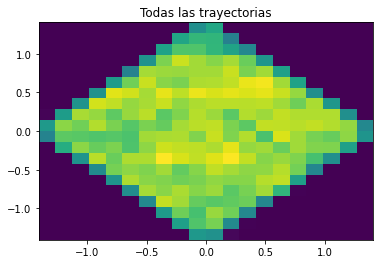

In [14]:
t_traject = train_traject2
linear_size = t_traject * N_despl


fig, ax = plt.subplots(1,1)
ax.hist2d(data_x, data_y, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])
plt.title('Todas las trayectorias')
plt.savefig('all_trajects1.png')
plt.show()

In [15]:
hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

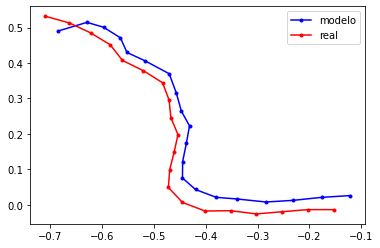

In [16]:
axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)

fig, ax = plt.subplots(1,1)
ax.plot(y2[-1,:,0].cpu().detach().numpy(), y2[-1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax.plot(batch_y1[-1,:,0].cpu().detach().numpy(), batch_y1[-1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.savefig('traject_example.png')
plt.show()

In [17]:
batch_y1[-1,:,:].shape

torch.Size([20, 2])

In [18]:
#y_rot_test

2


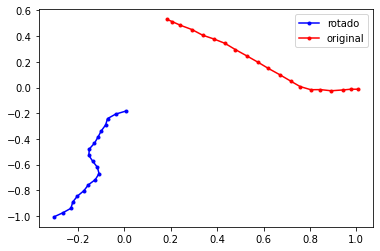

In [19]:
from rotation import rotate
y_rot_test = rotate(batch_y1[-20,:,:], 90)
fig, ax = plt.subplots(1,1)
ax.plot(y_rot_test[:,0], y_rot_test[:,1], c = 'b', label = 'rotado', marker = '.')
ax.plot(batch_y1[-20,:,0].cpu().detach().numpy(), batch_y1[-1,:,1].cpu().detach().numpy(), c = 'r', label = 'original', marker = '.')
plt.legend()
plt.show()

2


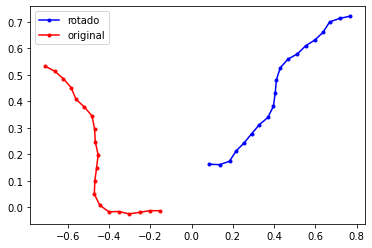

In [20]:
from rotation import rotate
y_rot_test2 = torch.from_numpy(y_rot_test)
y_rot_test2 = rotate(y_rot_test2, 210)
fig, ax = plt.subplots(1,1)
ax.plot(y_rot_test2[:,0], y_rot_test2[:,1], c = 'b', label = 'rotado', marker = '.')
ax.plot(batch_y1[-1,:,0].cpu().detach().numpy(), batch_y1[-1,:,1].cpu().detach().numpy(), c = 'r', label = 'original', marker = '.')
plt.legend()
plt.show()

In [21]:
last_loss = all_losses[-1]
print(last_loss)

tensor(0.3380, device='cuda:0')


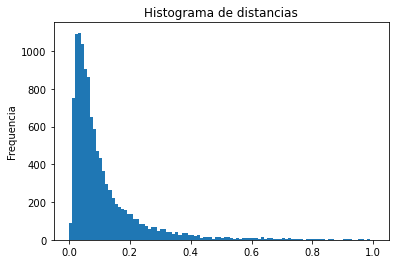

In [22]:
diferencia_array = np.zeros((2, y2[:,0,0].cpu().detach().numpy().size))

for i in range(y2[:,0,0].cpu().detach().numpy().size):
    x_dis, y_dis = distancia_modelo_real(y2[i, :, :].cpu().detach().numpy(), batch_y1[i, :, :].cpu().detach().numpy())
    diferencia_array[:,i] = [x_dis, y_dis]

plt.hist(diferencia_array[0,:], bins=100, range=[0, 1])
plt.gca().set(title='Histograma de distancias', ylabel='Frequencia')
plt.savefig('distance.png')
plt.show()

#diferenciar para ambos contextos el error y observar si hay alguno que sea peor que el otro

#buscar forma de calcular la correlacion entre las activaciones
#   a.- Calculando la interseccion entre ambos contextos ('rombo' interno entre los dos cuadrados)
#   b.- Poner los dos campos con el mismo tamaño maximo de eje praa que tenga la misma cantidad de bines el campo valido y quedarse con != nan

#si la correlacion da baja (el campo cambió) se aplica la transformacion de nuevo, si da alta, quiere decir que el cambio fue solo consecuencia
#de esa transformacion, si sigue baja, el cambio fue de otro tipo

#luego de ver la correlacion neurona a neurona se puede analizar a nivel global si hubo transformacion, por ejemplo si existe una rotacion
#a nivel global del mapa

In [23]:
all_activation.shape

torch.Size([11648, 20, 100])

In [24]:
batch_y1.cpu().detach().numpy().shape

(11648, 20, 2)

In [25]:
N_despl = 20
N_coord = 2
N_hidden_neurons = 100
N_softmax_neurons = 20
test_traject = 256
limit_arena = 1
limit_arena2 = -1

In [26]:
all_activation.shape

torch.Size([11648, 20, 100])

In [27]:
all_activation1 = np.reshape(all_activation.cpu().detach().numpy(), [128, -1, 20, 100], order = 'F')

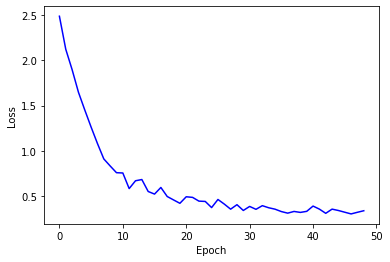

In [28]:
# t_traject = train_traject2
# linear_size = t_traject * N_despl
linear_size = t_traject * N_despl

all_activation1 = np.reshape(all_activation.cpu().detach().numpy(), [128, -1, 20, 100], order = 'F')
all_activation2 = all_activation1[64:,:,:,:]
all_activation3 = all_activation1[0:64,:,:,:]

act_array = np.array(all_activation2)
act_array1 = np.reshape(act_array, [linear_size, N_hidden_neurons], order = 'C')

final_array0 = np.zeros([20,20,N_hidden_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array0[xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1

plt.plot(all_losses[1:].cpu().detach().numpy(), c = 'b', label = 'total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('loss1.png')
plt.show()

In [29]:
all_trajects1 = np.reshape(batch_y1.cpu().detach().numpy(), [128, -1, 20, 2], order = 'F')
all_trajects2 = all_trajects1[64:,:,:,:]
all_trajects3 = all_trajects1[0:64,:,:,:]

all_trajects2.shape

(64, 91, 20, 2)

In [30]:
all_trajects1.shape

(128, 91, 20, 2)

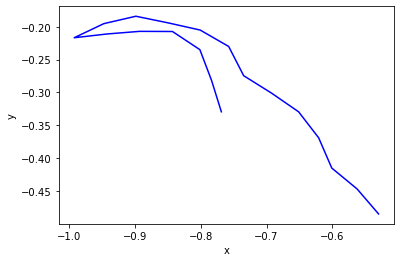

In [31]:
plt.plot(batch_y1[0,:,0].cpu().detach().numpy(), batch_y1[0,:,1].cpu().detach().numpy(), c = 'b', label = 'example_traject')
plt.ylabel('y')
plt.xlabel('x')
#plt.savefig('loss.png')
plt.show()

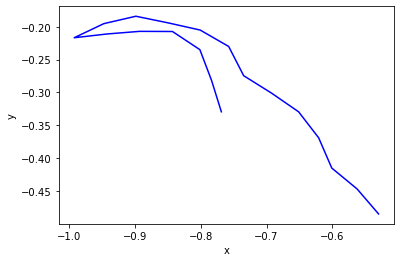

In [32]:
plt.plot(all_trajects3[0,0,:,0], all_trajects3[0,0,:,1], c = 'b', label = 'total')
plt.ylabel('y')
plt.xlabel('x')
#plt.savefig('loss.png')
plt.show()

Text(0.5, 0, 'Time')

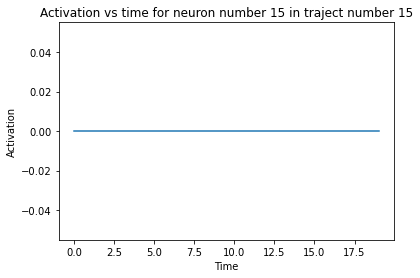

In [33]:
neuron = 15
traject = 15
plt.plot(all_activation3[traject,0,:,neuron])
plt.title(f'Activation vs time for neuron number {neuron} in traject number {traject}')
plt.ylabel('Activation')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

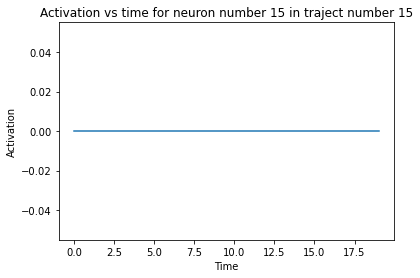

In [34]:
neuron = 15
traject = 15
plt.plot(all_activation.cpu().detach().numpy()[traject,:,neuron])
plt.title(f'Activation vs time for neuron number {neuron} in traject number {traject}')
plt.ylabel('Activation')
plt.xlabel('Time')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Hidden layer


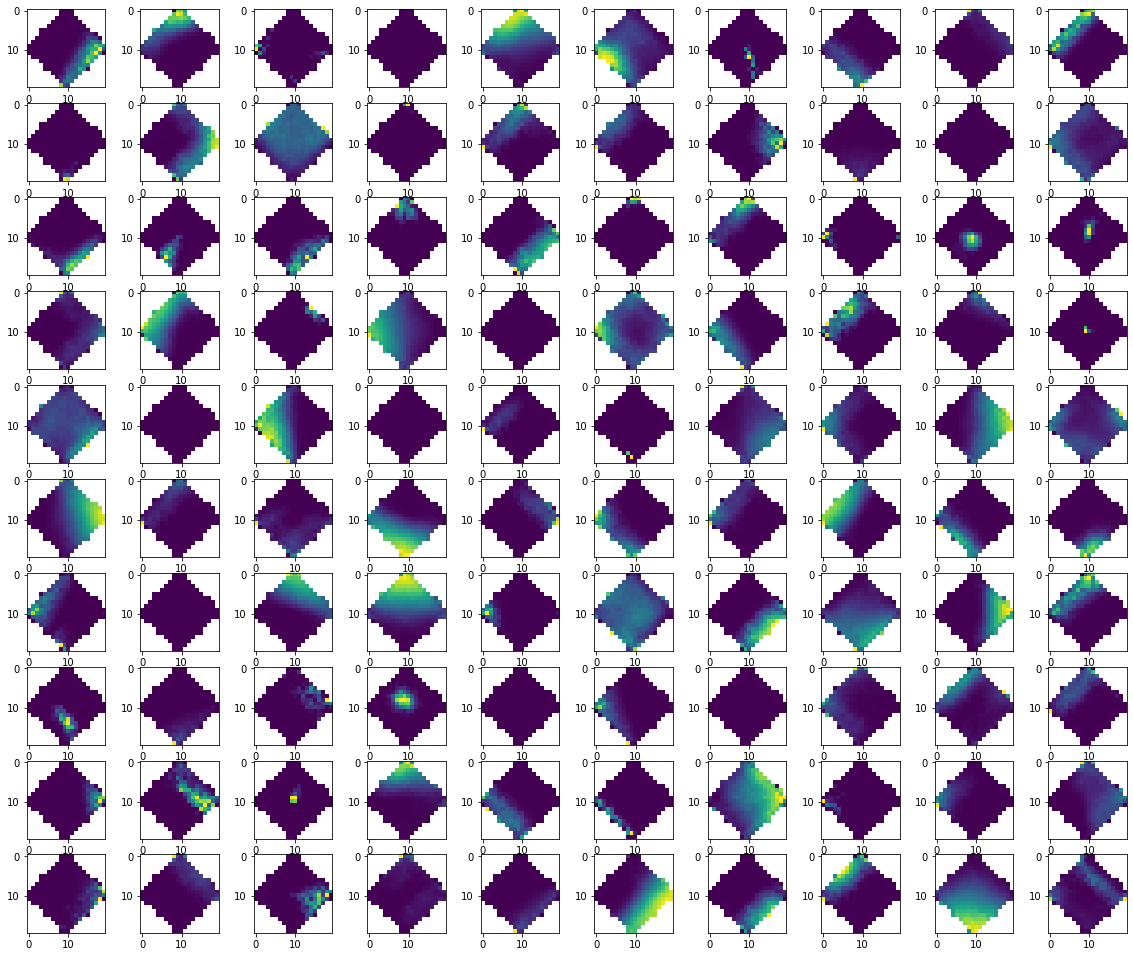

In [35]:
N_hidden_neurons = 100
final_array0 = final_array0 / counter
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array0[:,:,n])
print('Hidden layer')
plt.savefig('hidden_neurons.png')

#Var(Time, batch)   activaciones recurrente
#Ruido

#Mayor beta, ruido en la softmax también, =/= n° neuronas

In [36]:
def calculate_corr(context1, context2, n_neurons):
    
    correlations = []
    
    for neuron in range(n_neurons):
    
        arr7 = context1[:,:,neuron].copy()
        arr6 = context2[:,:,neuron].copy()
        arr7 = arr7[~(np.isnan(context1[:,:,neuron]) | np.isnan(context2[:,:,neuron]))]
        arr6 = arr6[~(np.isnan(context1[:,:,neuron]) | np.isnan(context2[:,:,neuron]))]

        arr6_f = arr6.flatten()
        arr7_f = arr7.flatten()
        corr = np.corrcoef(arr6_f, arr7_f)
        correlation = corr[0][1]
        
        correlations.append(correlation)
        
    return correlations

def calculate_corr_ind(context1, context2):
    
    correlations = []

    
    arr7 = context1.copy()
    arr6 = context2.copy()
    arr7 = arr7[~(np.isnan(context1) | np.isnan(context2))]
    arr6 = arr6[~(np.isnan(context1) | np.isnan(context2))]

    arr6_f = arr6.flatten()
    arr7_f = arr7.flatten()
    corr = np.corrcoef(arr6_f, arr7_f)
    correlation = corr[0][1]

    correlations.append(correlation)

    return correlations
# correlations = calculate_corr(final_array, final_array0, N_hidden_neurons)

# plt.hist(correlations)
# plt.title('Correlaciones')
# plt.savefig('correlations12.png')
# plt.show()

In [37]:
final_array0.shape

(20, 20, 100)

In [38]:
# neurons_corr = []
# for i in range(N_hidden_neurons):
#     correlations = calculate_corr_ind(final_array00[:,:,i], final_array002[:,:,i])
#     neurons_corr.append(correlations[0])

In [39]:
#np.where((neurons_corr_a > -0.05) & (neurons_corr_a < 0.05))

In [40]:
#neurons_corr_a[(neurons_corr_a > -0.05) & (neurons_corr_a < 0.05)]

In [41]:
#plt.imshow(final_array00[:,:,70])

In [42]:
#plt.imshow(final_array002[:,:,70])

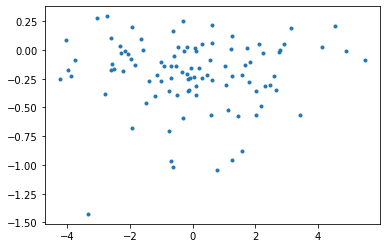

In [43]:
peso_input = my_network.linear.weight
peso_input21 = peso_input.cpu().detach().numpy()
plt.plot(peso_input21[:,0], peso_input21[:,2], ".")

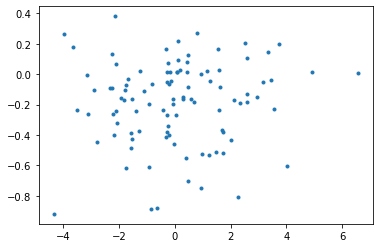

In [44]:
peso_input = my_network.linear.weight
peso_input21 = peso_input.cpu().detach().numpy()
plt.plot(peso_input21[:,1], peso_input21[:,3], ".")

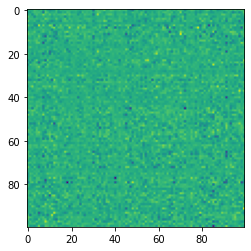

In [45]:
peso2 = my_network.linear2.weight
peso21 = peso2.cpu().detach().numpy()
plt.imshow(peso21)

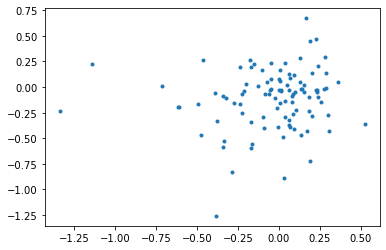

In [46]:
peso2 = my_network.linear2.weight
peso21 = peso2.cpu().detach().numpy()
plt.plot(peso21.T[:,0], peso21.T[:,1], ".")

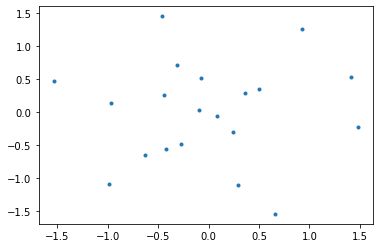

In [47]:

peso = my_network.linear3.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], ".")

In [48]:
peso.shape

torch.Size([2, 20])

In [49]:
from rotation import rotate

all_degs = [50,100,150,200,240,280,320]

corr_before = []

corr_after = []

for deg in all_degs:

    comp_deg = deg

    batch_y1_copy = batch_y1.clone().detach()
    batch_y9 = rotate(batch_y1_copy, comp_deg)

    batch_y3 = np.reshape(batch_y9, [128, -1, 20, 2], order = 'F')
    batch_y49 = batch_y3[64:,:,:,:]

    data_x01 = batch_y49[:,:,:,0].T
    data_y01 = batch_y49[:,:,:,1].T
    # data[20,224] or [32,20] tiempo,N_traject


    data_x01 = np.reshape(data_x01, -1, order='F')
    data_y01 = np.reshape(data_y01, -1, order='F')

    hist, *edges = np.histogram2d(data_x01, data_y01, bins=20, range=[[-np.max(data_x01), np.max(data_x01)], [-np.max(data_y01), np.max(data_y01)]])
    inx = np.digitize(data_x01, edges[0], right=True)
    iny = np.digitize(data_y01, edges[1], right=True)

    axisbins = list(zip(inx, iny))
    axisbins = np.array(axisbins)


    act_array = np.array(all_activation2)
    act_array1 = np.reshape(act_array, [linear_size, N_hidden_neurons], order = 'C')

    final_array00 = np.zeros([20,20,N_hidden_neurons])
    counter = np.zeros([20,20])
    counter = np.expand_dims(counter, 2)

    for n in range(linear_size):
        xbin = axisbins[n,0]
        ybin = axisbins[n,1]
        final_array00[xbin-1,ybin-1,:] += act_array1[n,:]
        counter[xbin-1,ybin-1] += 1

    final_array00 = final_array00 / counter

    data_x2 = batch_y5[:,:,:,0].T
    data_y2 = batch_y5[:,:,:,1].T
    # data[20,224] or [32,20] tiempo,N_traject


    data_x2 = np.reshape(data_x2, -1, order='F')
    data_y2 = np.reshape(data_y2, -1, order='F')

    t_traject = train_traject2
    linear_size = t_traject * N_despl

    hist, *edges = np.histogram2d(data_x2, data_y2, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])
    inx = np.digitize(data_x2, edges[0], right=True)
    iny = np.digitize(data_y2, edges[1], right=True)

    axisbins = list(zip(inx, iny))
    axisbins = np.array(axisbins)

    act_array = np.array(all_activation3)
    act_array1 = np.reshape(act_array, [linear_size, N_hidden_neurons], order = 'C')

    final_array = np.zeros([20,20,N_hidden_neurons])
    counter = np.zeros([20,20])
    counter = np.expand_dims(counter, 2)

    for n in range(linear_size):
        xbin = axisbins[n,0]
        ybin = axisbins[n,1]
        final_array[xbin-1,ybin-1,:] += act_array1[n,:]
        counter[xbin-1,ybin-1] += 1

    N_hidden_neurons = 100
    final_array = final_array / counter
    
    correlations = calculate_corr(final_array, final_array0, N_hidden_neurons)
    correlations2 = calculate_corr(final_array, final_array00, N_hidden_neurons)
    
    correlations11 = np.nan_to_num(correlations, copy=True)
    correlations22 = np.nan_to_num(correlations2, copy=True)
    

    corr_before.append(np.mean(correlations11))

    corr_after.append(np.mean(correlations22))

print(corr_before)

3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


3
3
3
3
3
3
[0.5000279423477606, 0.5000279423477606, 0.5000279423477606, 0.5000279423477606, 0.5000279423477606, 0.5000279423477606, 0.5000279423477606]


In [50]:
print(corr_after)

[0.24718754355906242, -0.09022036483048881, -0.21600831453815764, -0.22085714003992216, -0.12550898298573693, 0.06762863403640049, 0.33089404809907386]


Hidden reverse layer


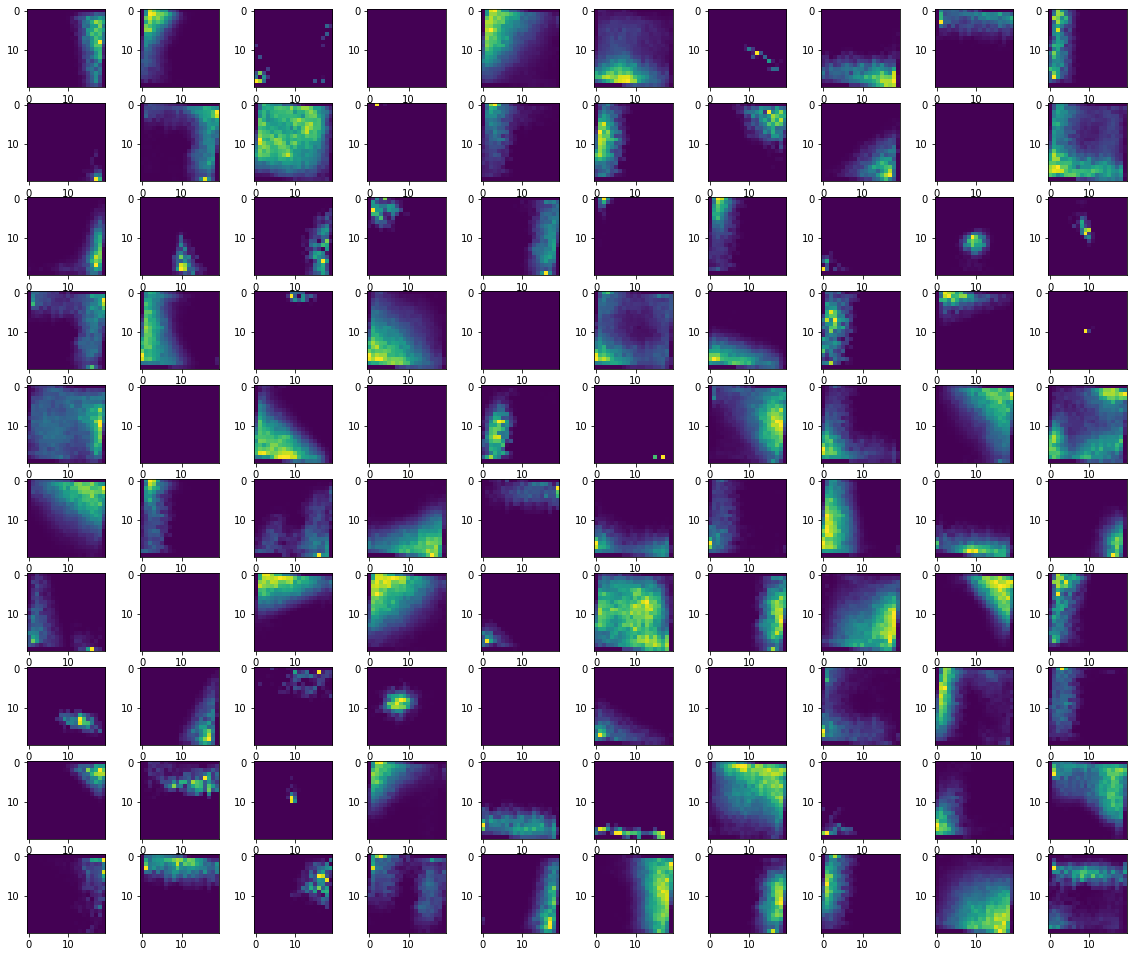

In [51]:
hist, *edges = np.histogram2d(data_x01, data_y01, bins=20, range=[[-np.max(data_x01), np.max(data_x01)], [-np.max(data_y01), np.max(data_y01)]])
inx = np.digitize(data_x01, edges[0], right=True)
iny = np.digitize(data_y01, edges[1], right=True)

axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)


act_array = np.array(all_activation2)
act_array1 = np.reshape(act_array, [linear_size, N_hidden_neurons], order = 'C')

final_array00 = np.zeros([20,20,N_hidden_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array00[xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1

plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array00[:,:,n])
plt.savefig('hidden_neurons_reverse.png')
print('Hidden reverse layer')

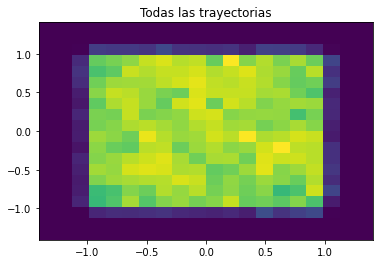

In [52]:
data_x2 = batch_y5[:,:,:,0].T
data_y2 = batch_y5[:,:,:,1].T
# data[20,224] or [32,20] tiempo,N_traject


data_x2 = np.reshape(data_x2, -1, order='F')
data_y2 = np.reshape(data_y2, -1, order='F')

t_traject = train_traject2
linear_size = t_traject * N_despl


fig, ax = plt.subplots(1,1)
ax.hist2d(data_x2, data_y2, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])
plt.title('Todas las trayectorias')
plt.savefig('all_trajects1.png')
plt.show()

In [53]:
axisbins.shape

(116480, 2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Hidden layer


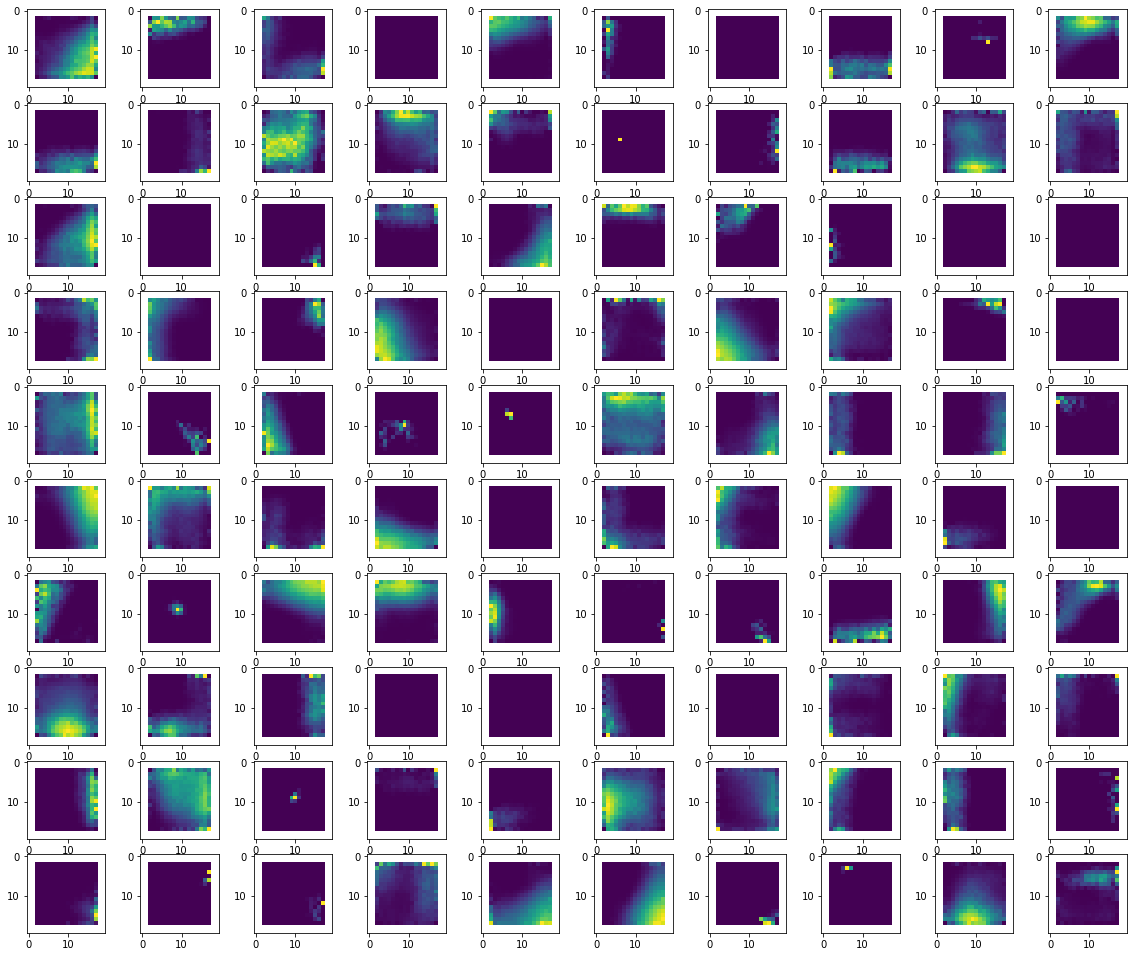

In [54]:
hist, *edges = np.histogram2d(data_x2, data_y2, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])
inx = np.digitize(data_x2, edges[0], right=True)
iny = np.digitize(data_y2, edges[1], right=True)

axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)

act_array = np.array(all_activation3)
act_array1 = np.reshape(act_array, [linear_size, N_hidden_neurons], order = 'C')

final_array001 = np.zeros([20,20,N_hidden_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array001 [xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1
    
N_hidden_neurons = 100
final_array002 = final_array001 / counter

plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array[:,:,n])
print('Hidden layer')
plt.savefig('hidden_neurons1.png')

In [55]:
final_array.shape

(20, 20, 100)

In [56]:
# from sklearn.decomposition import PCA

# final_array_all_pca = np.nan_to_num(final_array_all_pca, nan=0.0) #reemplazar por 0?


# pca = PCA()
# pca.fit(final_array_all_pca)

# explained_variance_ratio = pca.explained_variance_ratio_

# cumulative_explained_variance = np.cumsum(explained_variance_ratio[:10])
# plt.plot(cumulative_explained_variance, marker='x')
# plt.xlabel('Número de Componentes Principales')
# plt.ylabel('Varianza Explicada Acumulada')
# plt.title('Varianza Explicada por Componente Principal')
# plt.show()

In [57]:
# components = pca.transform(final_array_all_pca)
# components.shape

In [58]:
all_activation.shape

torch.Size([11648, 20, 100])

In [59]:
all_activation1 = np.reshape(all_activation.cpu().detach().numpy(), [128, -1, 20, 100], order = 'F')


def center_array(array, n_neurons):
    centered_array = np.zeros_like(array)
    for neuron in range(n_neurons):
        act_mean = float(np.mean(array[:, :, :, neuron]))
        
        centered_array[:, :, :, neuron] = array[:, :, :, neuron] - act_mean
        
    return centered_array
        

all_activation1_center = center_array(all_activation1, 100)

all_activation2 = all_activation1_center[64:,:,:,:]
all_activation3 = all_activation1_center[0:64,:,:,:]

In [60]:
torch.save(all_activation1_center, "all_activation1t.pt")


In [61]:
all_activation1.shape  #all_activation reshaped

#Filas - tiempos, columnas - neuronas

(128, 91, 20, 100)

In [62]:
all_activation1 = np.reshape(all_activation.cpu().detach().numpy(), [128, -1, 20, 100], order = 'F')
all_activation2 = all_activation1[64:,:,:,:]
all_activation3 = all_activation1[0:64,:,:,:]

In [63]:
all_trajects1 = np.reshape(batch_y1.cpu().detach().numpy(), [128, -1, 20, 2], order = 'F')
all_trajects2 = all_trajects1[64:,:,:,:]
all_trajects3 = all_trajects1[0:64,:,:,:]

all_trajects2.shape

(64, 91, 20, 2)

Text(0.5, 0, 'Time')

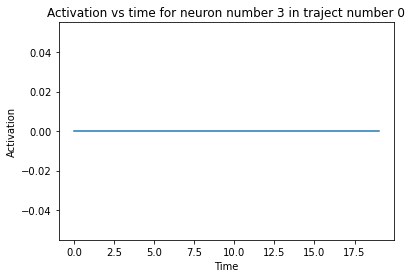

In [64]:
neuron = 3
traject = 0
plt.plot(all_activation1[traject,0,:,neuron])
plt.title(f'Activation vs time for neuron number {neuron} in traject number {traject}')
plt.ylabel('Activation')
plt.xlabel('Time')

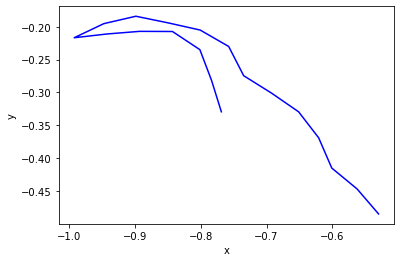

In [65]:
plt.plot(all_trajects3[traject,0,:,0], all_trajects3[traject,0,:,1], c = 'b', label = 'total')
plt.ylabel('y')
plt.xlabel('x')
#plt.savefig('loss.png')
plt.show()

In [66]:
all_activation.cpu().detach().numpy().shape

(11648, 20, 100)

In [67]:
all_activation1_b = np.reshape(all_activation1, [232960, 100], order = 'C')
all_activation2_b = all_activation1_b[116480:,:]
all_activation3_b = all_activation1_b[0:116480,:]

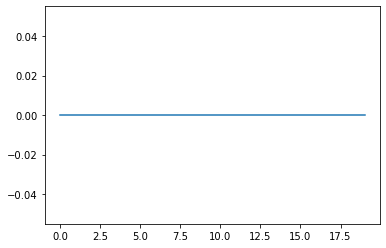

In [68]:
plt.plot(all_activation3_b[0:20,3])

In [69]:
all_activation.shape

torch.Size([11648, 20, 100])

In [70]:
all_activation1 = np.reshape(all_activation.cpu().detach().numpy(), [128, -1, 20, 100], order = 'F')
all_activation_pca2 = all_activation1[64:,:,:,:]
all_activation_pca3 = all_activation1[0:64,:,:,:]

all_activation_pca2 = np.reshape(all_activation_pca2, [116480, 100], order = 'C')
all_activation_pca3 = np.reshape(all_activation_pca3, [116480, 100], order = 'C')

all_activation_pca4 = np.vstack((all_activation_pca2, all_activation_pca3))
all_activation_pca4.shape

(232960, 100)

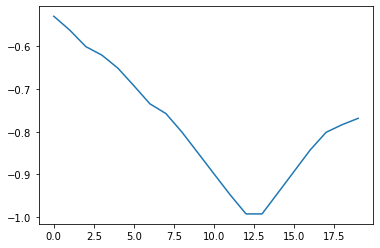

In [71]:
plt.plot(all_trajects3[0,0,:,0])

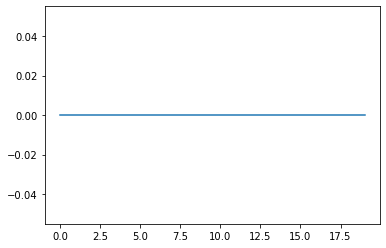

In [72]:
plt.plot(all_activation_pca3[0:20,3])

In [73]:
all_activation_pca4.shape

(232960, 100)

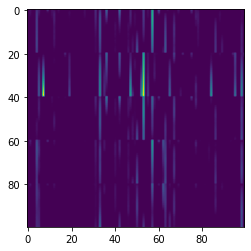

In [74]:
plt.imshow(all_activation_pca2[0:100,:])

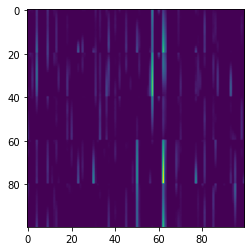

In [75]:
plt.imshow(all_activation_pca3[0:100,:])

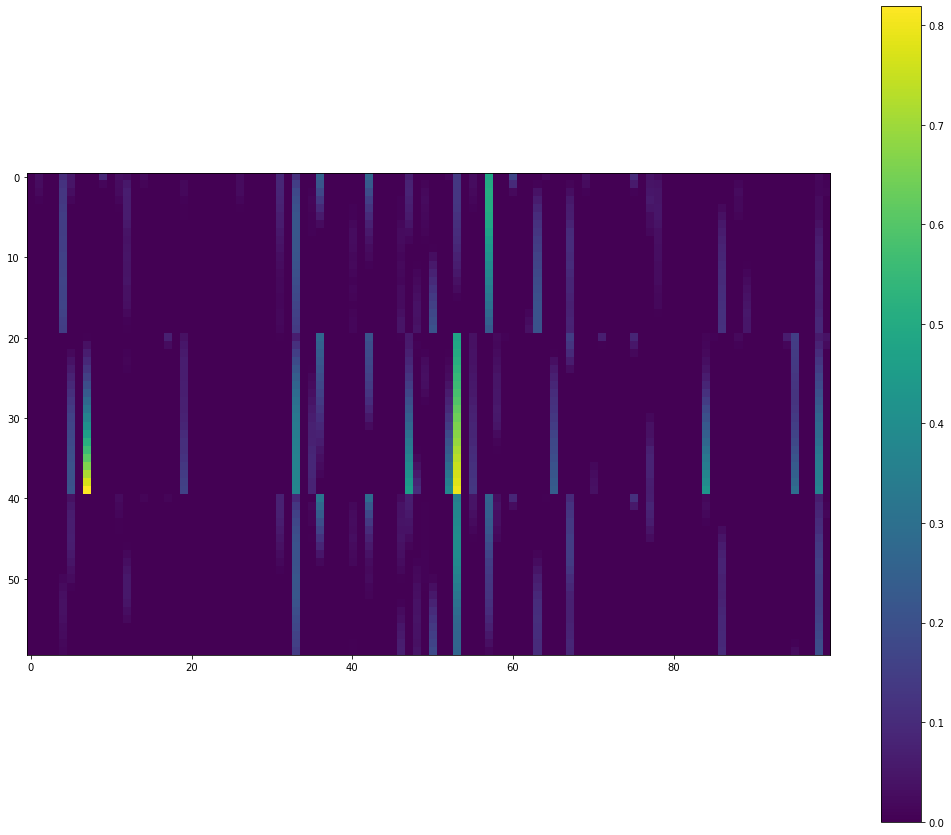

In [76]:
plt.figure(figsize=(18, 15))
plt.imshow(all_activation_pca4[0:60,:])
plt.colorbar()

In [109]:
from sklearn.decomposition import PCA

pca = PCA()
components2 = pca.fit_transform(all_activation_pca4)
torch.save(components2, "components2.pt")
components2.shape


(232960, 100)

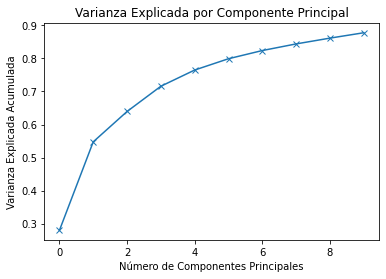

In [110]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio[:10])
plt.plot(cumulative_explained_variance, marker='x')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componente Principal')
plt.savefig('pca_variance.png')
plt.show()

<ul></ul>

<ul>
<li>PCA con diferentes angulos, si pocos componentes explican mucha var, usar aligment, sobretodo ver en angulos pequeños</li>
<li>Comparar los errores del modelo entrenado en un contexto y comparado con el target de ese mismo contexto y con el otro contexto para chequear si el modelo está generando un solo codigo para los dos contextos</li>
    
</ul>

In [111]:
comp21 = components2[116480:,:]
comp22 = components2[0:116480,:]
comp21.shape

(116480, 100)

In [112]:
torch.save(comp21, "comp21.pt")
torch.save(comp22, "comp22.pt")

In [113]:
type(comp21)

numpy.ndarray

# correlation en un mapa de disparo en ambos contextos
# neuronas con peso sinaptico mas grande deberian aportar mas a la diferenciacion de contexto


In [81]:
comp21 = comp21 - np.mean(comp21, axis=0, keepdims=True)
comp21.shape

(116480, 100)

In [82]:
comp22 = comp22 - np.mean(comp22, axis=0, keepdims=True)
comp22.shape

(116480, 100)

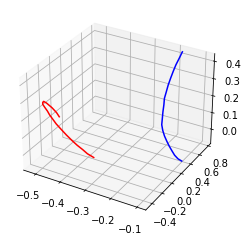

In [84]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(comp22[20:40,0], comp22[20:40,1], comp22[20:40,2], 'b')
ax.plot3D(comp21[20:40,0], comp21[20:40,1], comp21[20:40,2], 'r')

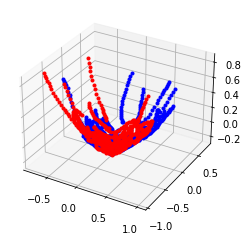

In [85]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(comp22[0:800,0], comp22[0:800,1], comp22[0:800,2], 'b.')
ax.plot3D(comp21[0:800,0], comp21[0:800,1], comp21[0:800,2], 'r.')

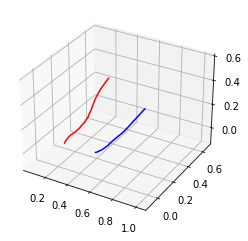

In [114]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(comp22[160:180,0], comp22[160:180,1], comp22[160:180,2], 'b')
ax.plot3D(comp21[160:180,0], comp21[160:180,1], comp21[160:180,2], 'r')

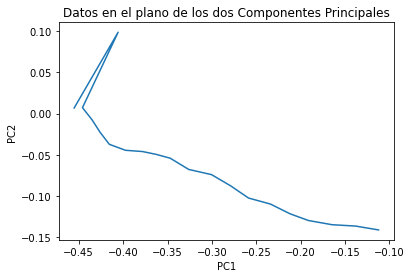

In [115]:
plt.plot(comp22[:20, 0], comp22[:20, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Datos en el plano de los dos Componentes Principales')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Softmax layer


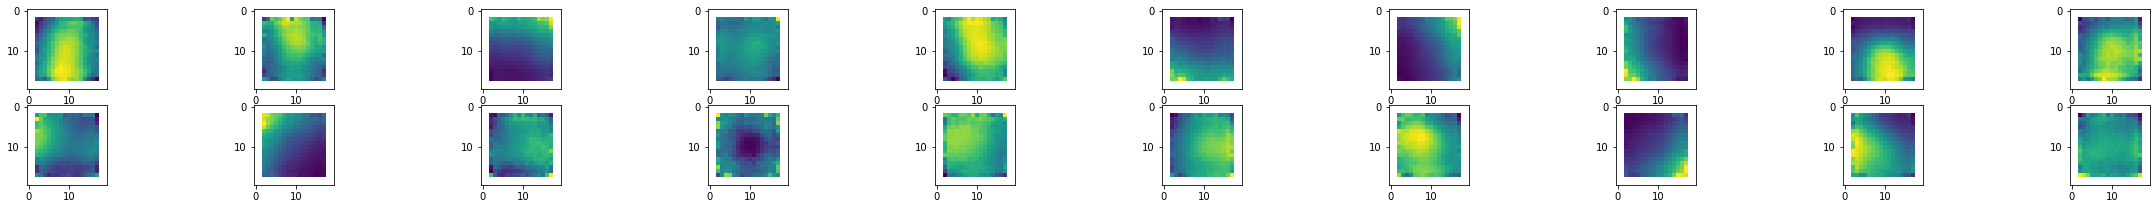

In [88]:
N_softmax_neurons = 20

act_array_soft = np.reshape(all_activation_soft.cpu().detach().numpy(), [128, -1, 20, N_softmax_neurons], order = 'F')
all_activation_soft2 = act_array_soft[64:,:,:,:]
all_activation_soft3 = act_array_soft[0:64,:,:,:]

act_array3 = np.array(all_activation_soft3)
act_array3 = np.reshape(act_array3, [linear_size, N_softmax_neurons], order = 'C')

final_array_soft = np.zeros([20,20,N_softmax_neurons])
counter_soft = np.zeros([20,20])
counter_soft = np.expand_dims(counter_soft, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array_soft[xbin-1,ybin-1,:] += act_array3[n,:]
    counter_soft[xbin-1,ybin-1] += 1

    

final_array_soft = final_array_soft / counter_soft

plt.figure(figsize=(40, 35))
for n in range(N_softmax_neurons):
    ax = plt.subplot(20, 10, n + 1)
    ax.imshow(final_array_soft[:,:,n])
print('Softmax layer')
plt.savefig('softmax_neurons.png')

In [89]:
linear_size

116480

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Softmax layer 2


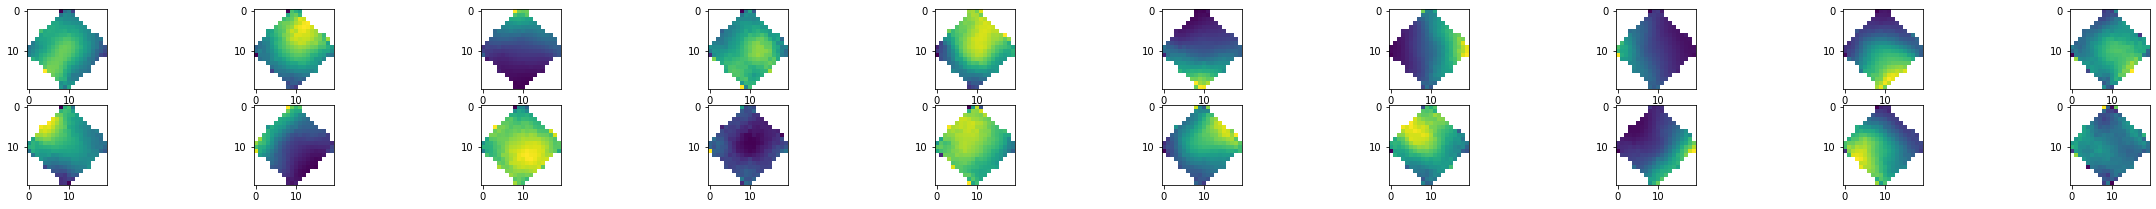

In [90]:
hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)

act_array22 = np.array(all_activation_soft2)
act_array22 = np.reshape(act_array22, [linear_size, N_softmax_neurons], order = 'C')

final_array_soft2 = np.zeros([20,20,N_softmax_neurons])
counter_soft2 = np.zeros([20,20])
counter_soft2 = np.expand_dims(counter_soft2, 2)

for m in range(linear_size):
    xbin = axisbins[m,0]
    ybin = axisbins[m,1]
    final_array_soft2[xbin-1,ybin-1,:] += act_array22[m,:]
    counter_soft2[xbin-1,ybin-1] += 1

    

final_array_soft2 = final_array_soft2 / counter_soft2

plt.figure(figsize=(40, 35))
for n in range(N_softmax_neurons):
    ax = plt.subplot(20, 10, n + 1)
    ax.imshow(final_array_soft2[:,:,n])
print('Softmax layer 2')
plt.savefig('softmax_neurons2.png')

In [91]:
final_array_soft.shape

(20, 20, 20)

In [92]:
all_cor = []
for n in range(N_softmax_neurons):
    corr_neu = calculate_corr_ind(final_array_soft[:,:,n], final_array_soft2[:,:,n])
    all_cor.append(corr_neu)

In [116]:
components4.shape

(232960, 20)

In [117]:
comp31 = components4[116480:,:]
comp32 = components4[0:116480,:]

In [119]:
comp31.shape

(116480, 20)

In [121]:
torch.save(comp31, "comp31.pt")

In [ ]:
torch.save(comp32, "comp32.pt")

# Alineacion en softmax
# Entrenar modelo sin softmax
# Recalibrar el numero de neuronas en ambas capas

graficos:
    - PCA, cómo da
    - Angulo que maximiza correlación neurona a neurona
    - Como da la alineacion

In [93]:
all_cor

[[0.5511811432244789],
 [0.842422741744401],
 [0.9567665911056658],
 [0.29001140295896194],
 [0.8681689356400026],
 [0.9677967744916816],
 [0.9224469363052237],
 [0.9726008857792421],
 [0.9699798610132337],
 [0.6964279389345105],
 [0.7488815144728036],
 [0.9746405867268595],
 [0.13307689259317465],
 [0.6706776574724961],
 [0.8702721273594037],
 [0.6492304739477341],
 [0.42937323476051326],
 [0.9698077142995986],
 [0.9518634349342814],
 [-0.060693366736506056]]

In [94]:
torch.save(act_array_soft, "all_activation_soft.pt")

In [95]:
all_activation_soft1 = np.reshape(all_activation_soft.cpu().detach().numpy(), [128, -1, 20, 20], order = 'F')
all_activation_soft_pca2 = all_activation_soft1[64:,:,:,:]
all_activation_soft_pca3 = all_activation_soft1[0:64,:,:,:]

all_activation_soft_pca2 = np.reshape(all_activation_soft_pca2, [116480, 20], order = 'C')
all_activation_soft_pca3 = np.reshape(all_activation_soft_pca3, [116480, 20], order = 'C')

all_activation_soft_pca4 = np.vstack((all_activation_soft_pca2, all_activation_soft_pca3))

In [96]:
all_activation_soft_pca4.shape

(232960, 20)

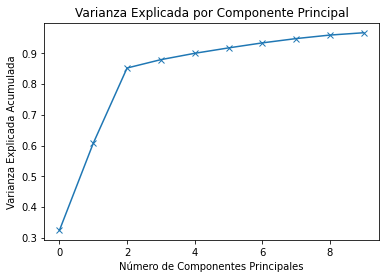

In [97]:

from sklearn.decomposition import PCA

pca_soft = PCA()
components4 = pca_soft.fit_transform(all_activation_soft_pca4)
torch.save(components4, "components4.pt")
components4.shape
explained_variance_ratio = pca_soft.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio[:10])
plt.plot(cumulative_explained_variance, marker='x')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componente Principal')
plt.savefig('pca_variance.png')
plt.show()

In [98]:
components4.shape

(232960, 20)

In [99]:
comp21 = components4[116480:,:]
comp22 = components4[0:116480,:]
comp21.shape

(116480, 20)

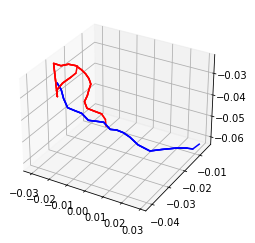

In [100]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

for i in range(0,3):
    traject = comp22[i:20,0:3]
    traject2 = comp22[i+64:i+84,0:3]
    x=traject[:,0]
    y=traject[:,1]
    t=traject[:,2]
    ax.plot3D(x, y, t, 'b')
    x2=traject2[:,0]
    y2=traject2[:,1]
    t2=traject2[:,2]
    ax.plot3D(x2, y2, t2, 'r')

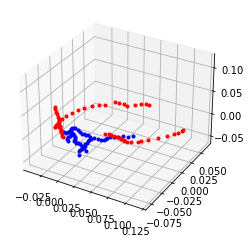

In [101]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(comp22[60:120,0], comp22[60:120,1], comp22[60:120,2], 'b.')
ax.plot3D(comp21[60:120,0], comp21[60:120,1], comp21[60:120,2], 'r.')

In [102]:
# for t in range(3):
#     traject = components2[t,:,0:2]
#     plt.plot(traject[:,0],traject[:,1])

In [103]:
from test import Testing
import numpy as np
N_despl = 20
N_coord = 2
N_hidden_neurons = 100
N_softmax_neurons = 20
test_traject = 256
limit_arena = 1
limit_arena2 = -1

t_traject = test_traject
        
test = Testing()
loss1, loss_switch, all_activation_test, all_activation_soft_test, batch_y1, y2, my_network  = test.test_model()

linear_size = t_traject * N_despl

data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')

hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)


act_array_test = np.array(all_activation_test.cpu().detach().numpy())
act_array1 = np.reshape(act_array_test, [linear_size, N_hidden_neurons], order = 'C')

final_array = np.zeros([20,20,N_hidden_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array[xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1
    
print(f'loss = {loss1}')
print(f'loss = {loss_switch}')
print('done')

final_array3 = final_array / counter

Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
3
2
loss = 0.3235693871974945
loss = 0.32340630888938904
done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


Hidden layer


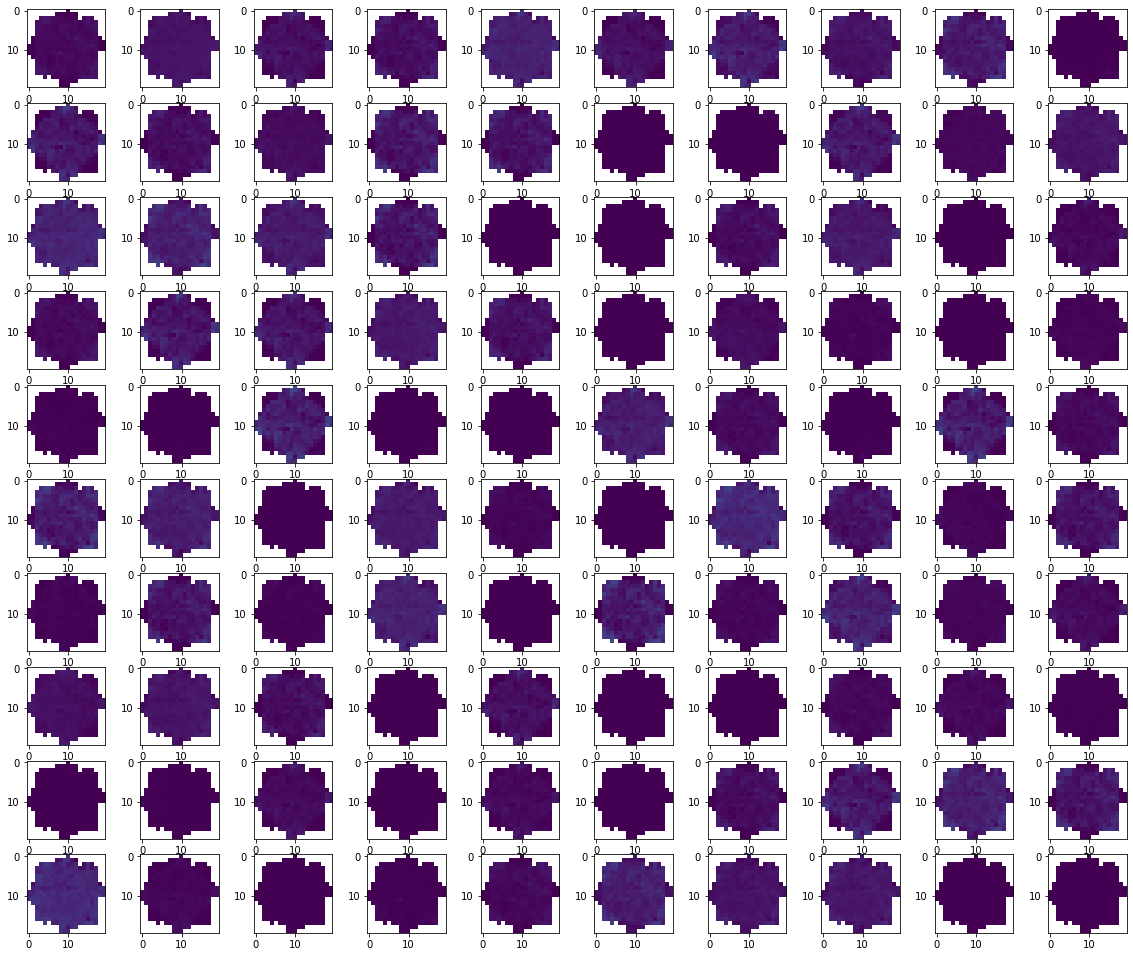

In [104]:
import matplotlib.pyplot as plt

N_hidden_neurons = 100
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array3[:,:,n], vmin=0, vmax=1)
print('Hidden layer')
plt.savefig('hidden_neurons.png')

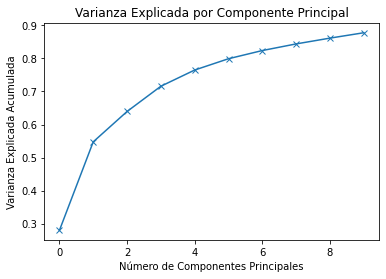

In [105]:
from sklearn.decomposition import PCA

#final_array_all_pca = np.nan_to_num(final_array_all_pca, nan=0.0) #reemplazar por 0?


pca_soft = PCA()
pca_soft.fit(all_activation_pca4)

explained_variance_ratio = pca_soft.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio[:10])
plt.plot(cumulative_explained_variance, marker='x')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componente Principal')
plt.show()

In [106]:
final_array_all_pca.shape

NameError: name 'final_array_all_pca' is not defined

In [ ]:
components1 = pca.transform(final_array_all_pca)
components_2d = components1[:,0:2]

plt.scatter(components_2d[:, 0], components_2d[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Datos en el plano de los dos Componentes Principales')
plt.show()

In [ ]:
#final_array_all_pca = np.nan_to_num(final_array_all_pca, nan=0.0)

components1 = pca.transform(all_activation_pca4)

components2 = components1[0:400]
components3 = components1[400:800]

final_array_all_pca2 = np.reshape(components2, [20, 20], order = 'C')
final_array_all_pca3 = np.reshape(components3, [20, 20], order = 'C')

plt.imshow(final_array_all_pca2, vmin=0, vmax=0.3)


# plt.scatter(components_2d[:, 0], components_2d[:, 1])
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('Datos en el plano de los dos Componentes Principales')
# plt.show()

In [ ]:
plt.imshow(final_array_all_pca3, vmin=0, vmax=0.3)

In [ ]:
def check_contexts(n):
    arr7 = final_array0[:,:,n].copy()
    arr6 = final_array[:,:,n].copy()
    arr7[(np.isnan(final_array[:,:,n]) | np.isnan(final_array0[:,:,n]))] = np.nan
    arr6[(np.isnan(final_array[:,:,n]) | np.isnan(final_array0[:,:,n]))] = np.nan

    plots = [final_array0[:,:,n],arr7, final_array[:,:,n], arr6]
    plt.figure(figsize=(15, 4))
    for n in range(4):
        ax = plt.subplot(1,4,n+1)
        ax.imshow(plots[n], vmin=0, vmax=0.1)
        
check_contexts(5)

#procrustian transformations
#Probar hipotesis: el remapeo es una simple rotación. Hago 'ingenieria inversa' de la activacion del contexto rotado

#1.- Son transformaciones lineales?
#  a.- Se propone transformación X > se testea > si ajusta la respuesta a 1 es si
#2.- Existen transformaciones a nivel global? Tiene sentido analizarlo solo a nivel neurona?

#A nivel distribucion de correlaciones analizar si cambia mucho o no la distribucion en relacion al angulo
#Por ejemplo es esperable que con angulos chicos tener correlaciones cercanas a 1 y a mayor angulo veria valores mas chicos
#Kolmogorov-smirnof two samples

In [ ]:
correlations[28]

In [ ]:
plt.imshow(final_array[:,:,28])

In [ ]:
plt.imshow(final_array0[:,:,28])

In [ ]:
correlations = calculate_corr(final_array, final_array0, N_hidden_neurons)

plt.hist(correlations)
plt.title('Correlaciones')
plt.savefig('correlations12.png')
plt.show()

In [ ]:
correlations2 = calculate_corr(final_array, final_array00, N_hidden_neurons)

plt.hist(correlations2)
plt.title('Correlations reversed')
plt.savefig('correlations_reversed.png')
plt.show()


#repetir muchas veces, calcular media y observar la relacion media con angulo
#angulos rectos

#tangente hiperbolica inversa? buscar a ver si es util para transformar las correlaciones
#Fisher_transformation

#buscar angulo que mejor explica remapeo

In [ ]:
correlations11 = np.nan_to_num(correlations, copy=True)
correlations22 = np.nan_to_num(correlations2, copy=True)

In [ ]:
print('antes')
print(f'Media: {np.mean(correlations11)}')
print(f'Desvio: {np.std(correlations11)}')

print('despues')
print(f'Media: {np.mean(correlations22)}')
print(f'Desvio: {np.std(correlations22)}')

In [ ]:
final_array[:,:,0].flatten().shape

In [ ]:
plt.scatter(final_array[:,:,59].flatten(), final_array0[:,:,59].flatten())

In [ ]:
# arr7 = final_array0[:,:,80].copy()
# arr6 = final_array[:,:,80].copy()
# arr7 = arr7[~(np.isnan(final_array[:,:,80]) | np.isnan(final_array0[:,:,80]))]
# arr6 = arr6[~(np.isnan(final_array[:,:,80]) | np.isnan(final_array0[:,:,80]))]

# arr6_f = arr6.flatten()
# arr7_f = arr7.flatten()
# corr = np.corrcoef(arr6_f, arr7_f)
# corr[0][1]

#Pasar a una funcion que se pueda llamar y sacar la correlacion para toda la poblacion
#Modificar beta para reducir el tamaño de place cells en softmax

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

ax1.plot(y2[0,:,0].cpu().detach().numpy(), y2[0,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax1.plot(batch_y1[0,:,0].cpu().detach().numpy(), batch_y1[0,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax2.plot(y2[1,:,0].cpu().detach().numpy(), y2[1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax2.plot(batch_y1[1,:,0].cpu().detach().numpy(), batch_y1[1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax3.plot(y2[2,:,0].cpu().detach().numpy(), y2[2,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax3.plot(batch_y1[2,:,0].cpu().detach().numpy(), batch_y1[2,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax4.plot(y2[3,:,0].cpu().detach().numpy(), y2[3,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax4.plot(batch_y1[3,:,0].cpu().detach().numpy(), batch_y1[3,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.savefig('traject_examples.png')

In [ ]:
# final_arrayplot = final_array / counter
# plt.figure(figsize=(20, 17))
# for n in range(N_hidden_neurons):
#     ax = plt.subplot(10, 10, n + 1)
#     ax.imshow(final_arrayplot[:,:,n], vmin=0, vmax=1)
# print('Hidden layer')
# plt.savefig('hidden_neurons1.png')


#discriminar las activaciones de un contexto y otro
#cuantificar si error en contexto 1 de estimacion con respecto a "realidad" del otro contexto es mayor al error de estimacion del mismo contexto
#verificar que esta haciendo la softmax

In [ ]:
sum(final_array_soft[0,0,:])

In [ ]:
data_x = batch_y4[:,:,:,0].T
data_y = batch_y4[:,:,:,1].T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')

t_traject = train_traject2
linear_size = t_traject * N_despl


fig, ax = plt.subplots(1,1)
ax.hist2d(data_x, data_y, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])

hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[-np.max(data_x), np.max(data_x)], [-np.max(data_y), np.max(data_y)]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)

In [ ]:
act_array2 = np.array(all_activation_soft2)
act_array2 = np.reshape(act_array2, [linear_size, N_softmax_neurons], order = 'C')

final_array_soft2 = np.zeros([20,20,N_softmax_neurons])
counter_soft = np.zeros([20,20])
counter_soft = np.expand_dims(counter_soft, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array_soft2[xbin-1,ybin-1,:] += act_array2[n,:]
    counter_soft[xbin-1,ybin-1] += 1
print('done')

In [ ]:
correlations = calculate_corr(final_array_soft, final_array_soft2, N_softmax_neurons)

plt.hist(correlations)
plt.title('Correlaciones softmax layer')
plt.savefig('correlations1.png')
plt.show()

In [ ]:
print(f'Media: {np.mean(correlations)}')
print(f'Desvio: {np.std(correlations)}')

In [ ]:
N_softmax_neurons = 20

plt.figure(figsize=(40, 35))
for n in range(N_softmax_neurons):
    ax = plt.subplot(20, 10, n + 1)
    ax.imshow(final_array_soft2[:,:,n])
print('Softmax layer')
plt.savefig('softmax_neurons1.png')

In [ ]:
plt.imshow(final_array_soft2[:,:,0], vmin=0, vmax=1)
plt.colorbar()


In [ ]:
sum(final_array_soft[0,0,:])

In [ ]:
sum(counter_soft[0,0,:])

In [ ]:
# final_array_soft = np.zeros([20,20,N_softmax_neurons])
# counter_soft = np.zeros([20,20])
# counter_soft = np.expand_dims(counter_soft, 2)

# for n in range(linear_size):
#     xbin = axisbins[n,0]
#     ybin = axisbins[n,1]
#     final_array_soft[xbin-1,ybin-1,:] += act_array2[n,:]
#     counter_soft[xbin-1,ybin-1] += 1
# print('done')

In [ ]:
# final_array_softmax = final_array_soft / counter_soft
# plt.figure(figsize=(40, 35))
# for n in range(N_softmax_neurons):
#     ax = plt.subplot(20, 10, n + 1)
#     ax.imshow(final_array_softmax[:,:,n], vmin=0, vmax=0.5)
# print('Softmax layer')
# plt.savefig('softmax_neurons1.png')


In [ ]:
peso = my_network.linear3.weight
peso2 = peso.cpu().detach().numpy().flatten()
plt.hist(peso2)

In [ ]:
peso = my_network.linear5.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], ".")

In [ ]:
peso = my_network.linear5.weight
peso1 = peso.cpu().detach().numpy().flatten()
plt.hist(peso1)

In [ ]:
peso = my_network.linear4.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], "x")

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

ax1.plot(y2[50,:,0].cpu().detach().numpy(), y2[50,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax1.plot(batch_y1[50,:,0].cpu().detach().numpy(), batch_y1[50,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax2.plot(y2[51,:,0].cpu().detach().numpy(), y2[51,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax2.plot(batch_y1[51,:,0].cpu().detach().numpy(), batch_y1[51,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax3.plot(y2[52,:,0].cpu().detach().numpy(), y2[52,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax3.plot(batch_y1[52,:,0].cpu().detach().numpy(), batch_y1[52,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax4.plot(y2[53,:,0].cpu().detach().numpy(), y2[53,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax4.plot(batch_y1[53,:,0].cpu().detach().numpy(), batch_y1[53,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()